Try to predict Ev vs. zero-set on a larger set of spuds

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures, normalize
from scipy.stats import pearsonr
from scipy.io import savemat

In [2]:
tab = pd.read_csv("temp_desL_evs_vs_zeroset.csv")

In [3]:
tab = tab.loc[:, ["h", "f", "l", "p", "r", "s", "vsSel"]]

In [4]:

pf = PolynomialFeatures(2, interaction_only = True)

In [5]:
X = np.array(tab.loc[:, ["h", "f", "l", "p", "r", "s"]])
X

array([[1, 2, 4, 6, 9, 9],
       [1, 2, 4, 7, 9, 9],
       [1, 2, 4, 8, 8, 9],
       ...,
       [9, 8, 2, 8, 2, 1],
       [9, 8, 2, 9, 1, 1],
       [9, 8, 2, 9, 2, 1]])

In [6]:
# def expand_x(X):
#     Xi = np.hstack([X] + [(X >= i) + 0 for i in np.arange(2, 10)])
#     return Xi

def expand_x(X):
    Xi = np.hstack([(X >= i) + 0 for i in np.arange(2, 10)])
    return Xi


Xi = expand_x(X)

In [7]:
ofs = ["h", "f", "l", "p", "r", "s"]
#featnames1 = np.concatenate([ofs] + list([['I(' + of + '>=' + str(i) + ')' for i in np.arange(2, 10)] for of in ofs]))
featnames1 = np.concatenate(list([['I(' + of + '>=' + str(i) + ')' for of in ofs] for i in np.arange(2, 10)]))
#featnames1 = np.concatenate([["inter"], featnames1])

In [8]:
#X2 = normalize(pf.fit_transform(Xi))
X2 = pf.fit_transform(Xi)
featnames2 = np.array(['*'.join(featnames1[np.nonzero(row)[0]]) for row in pf.powers_])
X2.shape


(330544, 1177)

In [9]:
y = tab.vsSel.values

In [10]:
n = len(y)
ntrain = int(n/2)
nval = int(n * .6)
nval

198326

In [11]:
from numpy.random import choice
perm = choice(n, n, replace = False)

In [12]:
Xtr = X2[perm[:ntrain]]
Xtv = X2[perm[ntrain:nval]]
Xraw_v = X[perm[ntrain:nval]]
Xte = X2[perm[nval:]]
ytr = y[perm[:ntrain]]
ytv = y[perm[ntrain:nval]]
yte = y[perm[nval:]]


In [13]:
from sklearn.linear_model import ElasticNet, LinearRegression

In [357]:
lm = ElasticNet(alpha = 1e-2, l1_ratio = 1.0)
#lm = LinearRegression(positive = True)

In [358]:
#lm.fit(Xtr, ytr)
#lm.fit(np.vstack([Xtr, 2 * np.ones((1, Xtr.shape[1]))]),  np.concatenate([ytr, [0]]))
lm.fit(Xtr, ytr)

ElasticNet(alpha=0.01, l1_ratio=1.0)

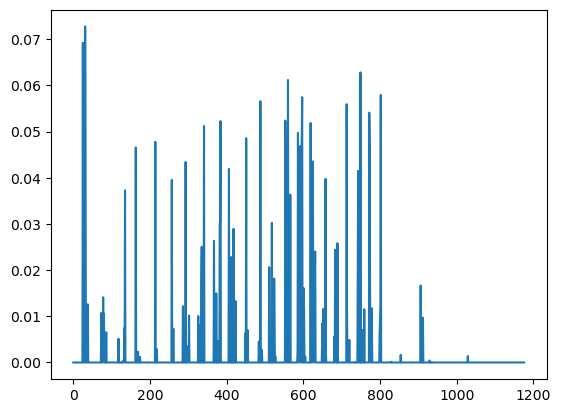

In [359]:
plt.plot(lm.coef_)

In [360]:
np.sum(lm.coef_ > 0)

133

In [361]:
lm.intercept_

-0.7627240916418548

In [362]:
pearsonr(ytv, lm.predict(Xtv))[0]

0.9438115216371086

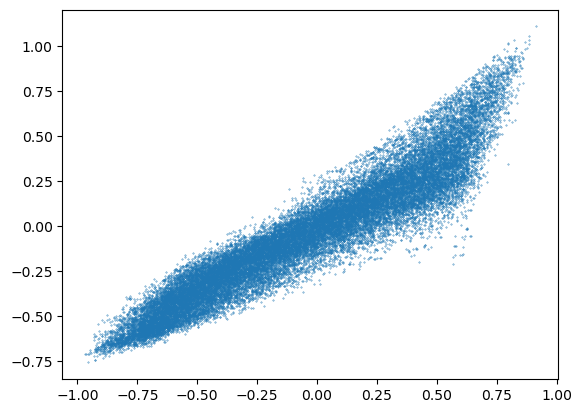

In [363]:
plt.scatter(ytv, lm.predict(Xtv), s = 0.1)

In [364]:
pf.powers_.shape

(1177, 48)

In [365]:
pd.DataFrame({'feat':featnames2[lm.coef_ > 0], 'coef':lm.coef_[lm.coef_ > 0]}).to_csv("temp_desL_wider_coefs.csv")

## interpret effects

In [366]:
order0_fx = lm.intercept_

In [367]:
# interpret effects by constructing test matrices
order1_fx = np.zeros((6, 10))
for i in range(6):
    test0 = np.zeros((10, 6))
    test0[:, i] = np.arange(10)
    testX = pf.fit_transform(expand_x(test0))
    order1_fx[i, :] = lm.predict(testX) - order0_fx

In [368]:
order1_fx[0, 4]

0.0

In [369]:
# test123 = np.zeros((10, 6))
# test123[:, 0] = np.arange(10)
# test123[:, 1] = np.arange(10)
# test123[:, 2] = np.arange(10)
# testX123 = pf.fit_transform(expand_x(test123))

# test12 = np.zeros((10, 6))
# test12[:, 0] = np.arange(10)
# test12[:, 1] = np.arange(10)
# testX12 = pf.fit_transform(expand_x(test12))

# test13 = np.zeros((10, 6))
# test13[:, 0] = np.arange(10)
# test13[:, 2] = np.arange(10)
# testX13 = pf.fit_transform(expand_x(test13))

# test23 = np.zeros((10, 6))
# test23[:, 1] = np.arange(10)
# test23[:, 2] = np.arange(10)
# testX23 = pf.fit_transform(expand_x(test23))

# test1 = np.zeros((10, 6))
# test1[:, 0] = np.arange(10)
# testX1 = pf.fit_transform(expand_x(test1))

# test2 = np.zeros((10, 6))
# test2[:, 1] = np.arange(10)
# testX2 = pf.fit_transform(expand_x(test2))

# test3 = np.zeros((10, 6))
# test3[:, 2] = np.arange(10)
# testX3 = pf.fit_transform(expand_x(test3))

# test0 = np.zeros((10, 6))
# testX0 = pf.fit_transform(expand_x(test0))

# o1sum = testX1 + testX2 + testX3 - 3 * testX0
# o2sum = testX12 + testX13 + testX23 - 2 * o1sum - 3 * testX0
# testXprime = testX0 + o1sum + o2sum

# pearsonr(testX123.flatten(), testXprime.flatten())

0

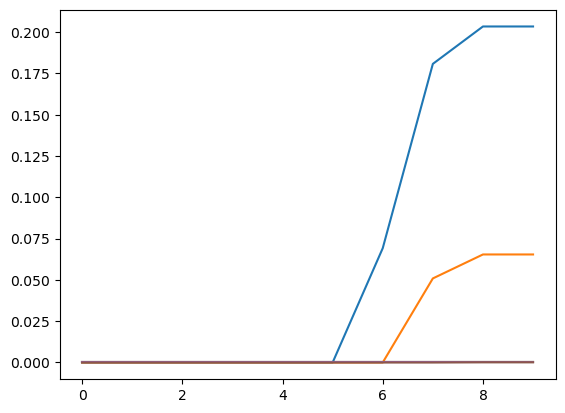

In [370]:
plt.plot(np.array(order1_fx).T)
0

In [382]:
order2_fx = np.zeros((6,6,10,10))

In [383]:
order2_fx.shape

(6, 6, 10, 10)

In [384]:
for i in range(6):
    for j in range(6):
        if i != j:
            for v_i in range(10):
                test0 = np.zeros((10, 6))
                test0[:, i] = v_i
                test0[:, j] = np.arange(10)
                testX = pf.fit_transform(expand_x(test0))
                order2_fx[i,j,v_i,:] = lm.predict(testX) - order0_fx - order1_fx[i, v_i] - order1_fx[j, :]

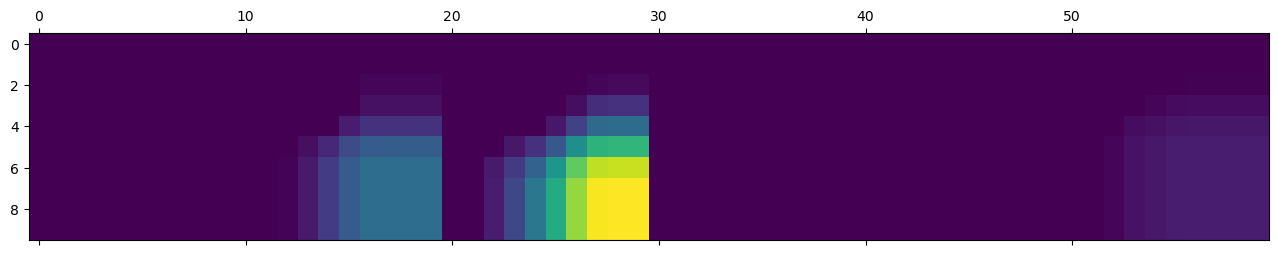

In [385]:
plt.matshow(np.hstack([order2_fx[0, i, :, :] for i in range(6)]))

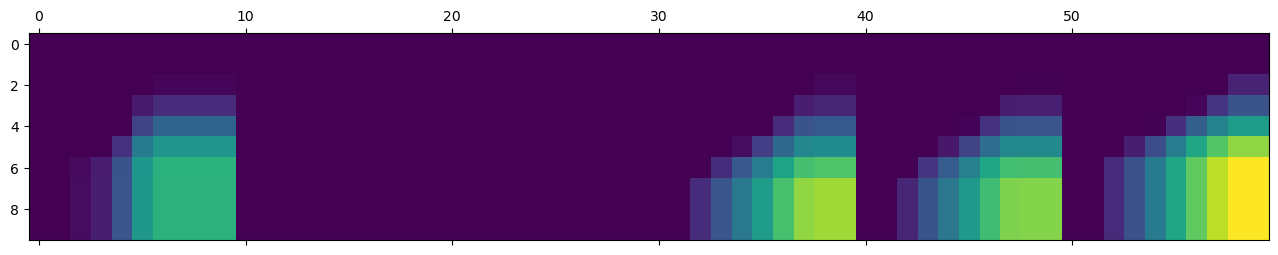

In [386]:
plt.matshow(np.hstack([order2_fx[1, i, :, :] for i in range(6)]))

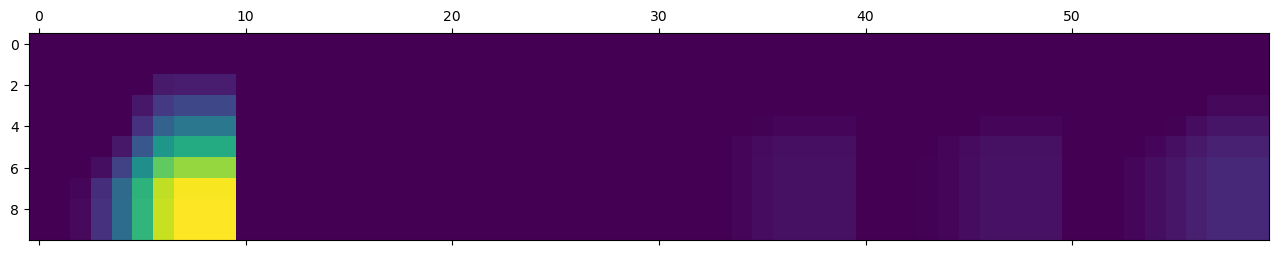

In [387]:
plt.matshow(np.hstack([order2_fx[2, i, :, :] for i in range(6)]))

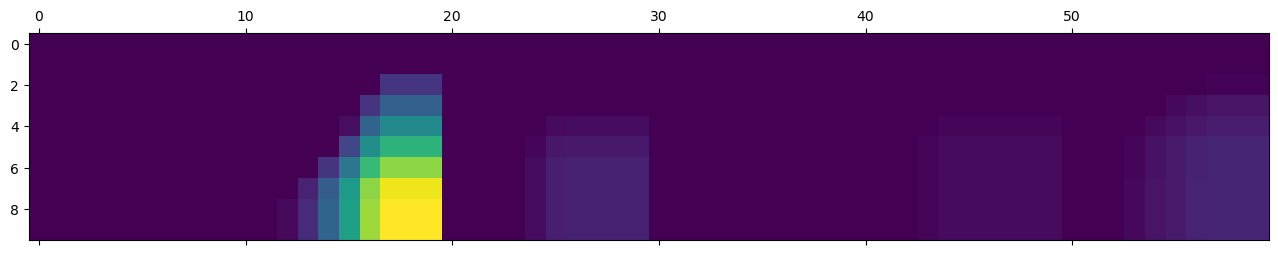

In [388]:
plt.matshow(np.hstack([order2_fx[3, i, :, :] for i in range(6)]))

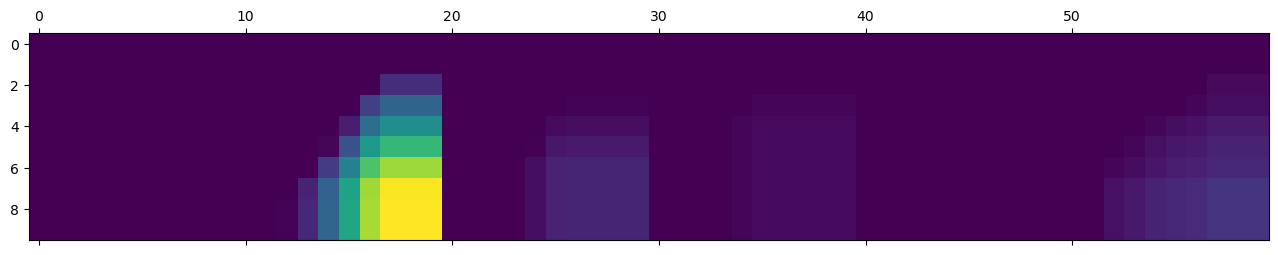

In [389]:
plt.matshow(np.hstack([order2_fx[4, i, :, :] for i in range(6)]))

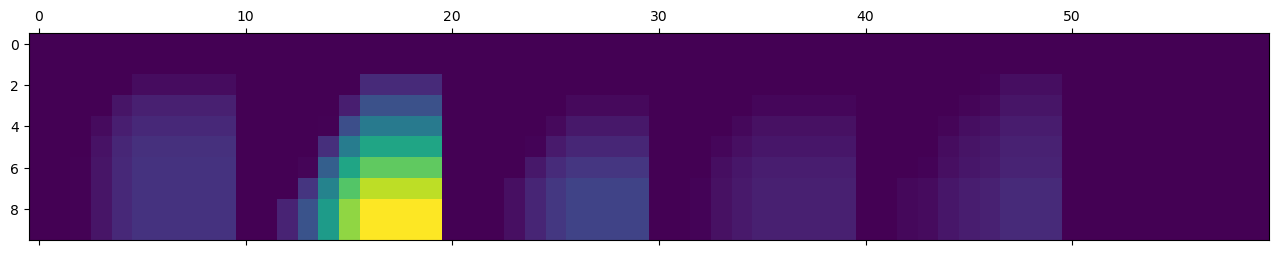

In [390]:
plt.matshow(np.hstack([order2_fx[5, i, :, :] for i in range(6)]))

In [391]:
def predict_x(x, f0, f1, f2):
    s = f0
    for i in range(6):
        s += f1[i,int(x[i])-1]
    for i in range(5):
        for j in range(i+1, 6):
            s += f2[i,j,int(x[i]),int(x[j])]
    return s

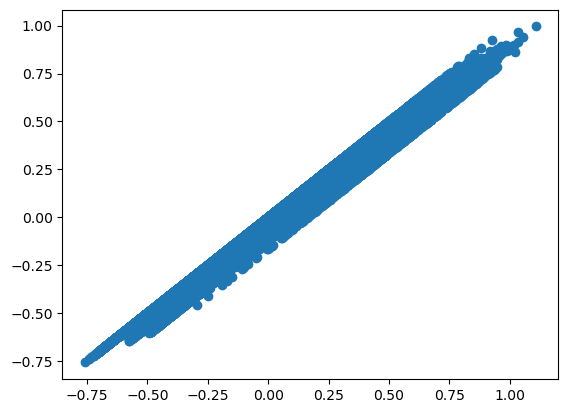

In [392]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xraw_v[i], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]))

In [393]:
pearsonr(lm.predict(Xtv), np.array([predict_x(Xraw_v[i], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]))

PearsonRResult(statistic=0.9933282204566001, pvalue=0.0)

In [394]:
pearsonr(lm.predict(Xtv), np.dot(Xtv, lm.coef_))

PearsonRResult(statistic=1.0, pvalue=0.0)

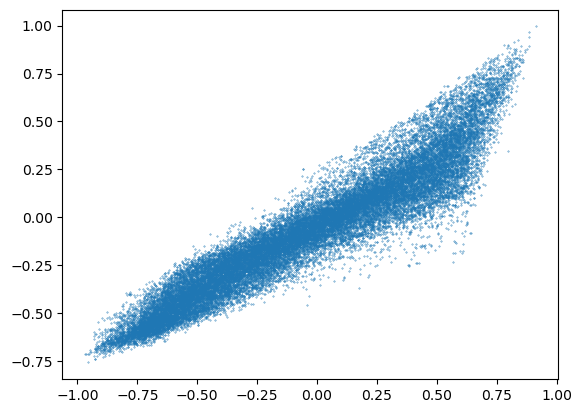

In [395]:
plt.scatter(ytv, np.array([predict_x(Xraw_v[i], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]), s = 0.1)

In [396]:
pearsonr(ytv, np.array([predict_x(Xraw_v[i], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))]))

PearsonRResult(statistic=0.9454799693318339, pvalue=0.0)

In [397]:
savemat("temp_desL_wider_regress.mat", {"b0": order0_fx, "b1": order1_fx, "b2": order2_fx})

In [420]:
ypv = np.array([predict_x(Xraw_v[i], order0_fx, order1_fx, order2_fx) for i in range(len(Xtv))])
diff = ytv - ypv

In [421]:
np.sum(diff[np.abs(ypv) < 0.01] > 0.1)

328

In [422]:
np.sort(diff[np.abs(ypv) < 0.01])[-10:]

array([0.49988513, 0.50034373, 0.51030331, 0.51158315, 0.51605124,
       0.51760557, 0.52662778, 0.55672509, 0.58695746, 0.60928129])

In [426]:
Xraw_v[np.abs(ypv) < 0.01][np.argsort(-diff[np.abs(ypv) < 0.01])[1:5]]

array([[3, 7, 1, 1, 9, 9],
       [9, 7, 2, 2, 2, 4],
       [3, 7, 2, 9, 1, 9],
       [2, 9, 6, 9, 7, 1]])

In [427]:
predict_x([9, 7, 1, 1, 1, 1], order0_fx, order1_fx, order2_fx)

-0.32362994939262046

In [424]:
ypv[np.abs(ypv) < 0.01][np.argsort(-diff[np.abs(ypv) < 0.01])[1:5]]

array([-0.00045746,  0.00577491,  0.00437222, -0.00560557])

In [425]:
ytv[np.abs(ypv) < 0.01][np.argsort(-diff[np.abs(ypv) < 0.01])[1:5]]

array([0.5865, 0.5625, 0.531 , 0.512 ])

## Try rank-1 approx

In [399]:
def monotonize(v):
    for i in range(1, len(v)):
        v[i] = np.max(v[:(i+1)])
    return v

In [345]:
# how well would a low-rank approx work?
def rk1approx(a):
    cm = monotonize(np.mean(a, 0))
    rm = monotonize(np.mean(a, 1))
    a2 = cm.reshape((10, 1)) * rm.reshape((1, 10))
    scale = np.max(a)/np.max(a2)
    a2 = scale * a2
    return a2

f0 = order0_fx
f1 = order1_fx
f2 = order2_fx

for i in range(6):
    for j in range(6):
        if np.max(np.abs(f2[i, j, :, :])) > 0.001:
            f2[i, j, :, :] = rk1approx(f2[i, j, :, :])
        else:
            f2[i, j, :, :] = 0

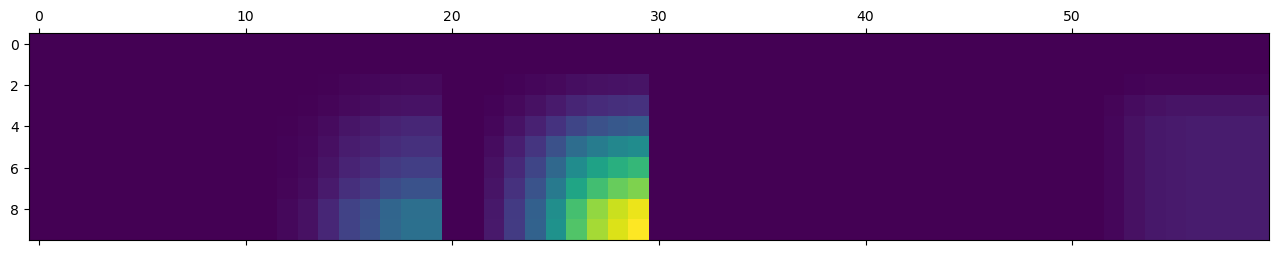

In [346]:
plt.matshow(np.hstack([f2[0, i, :, :] for i in range(6)]))

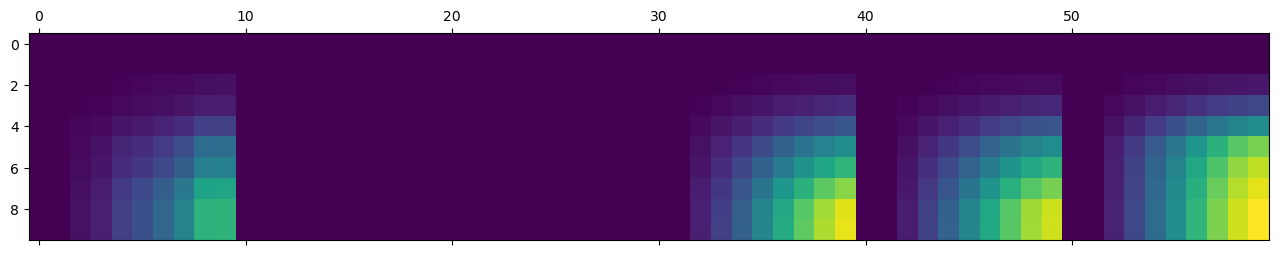

In [347]:
plt.matshow(np.hstack([f2[1, i, :, :] for i in range(6)]))

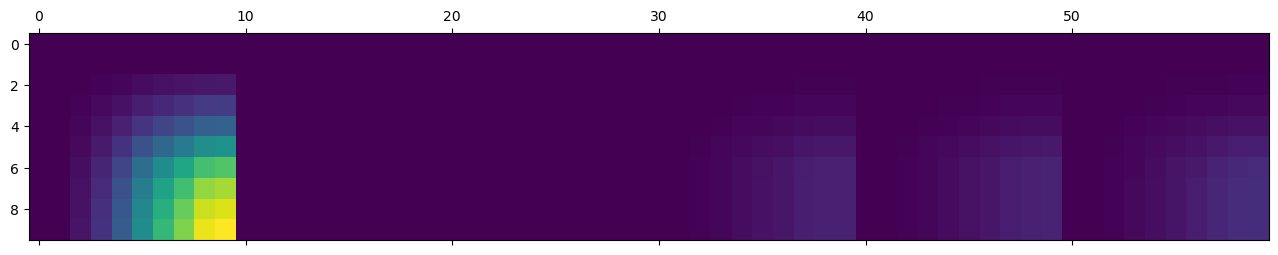

In [348]:
plt.matshow(np.hstack([f2[2, i, :, :] for i in range(6)]))

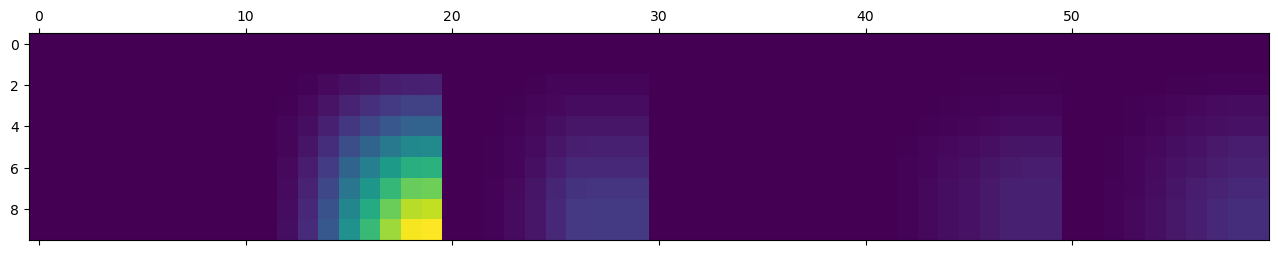

In [349]:
plt.matshow(np.hstack([f2[3, i, :, :] for i in range(6)]))

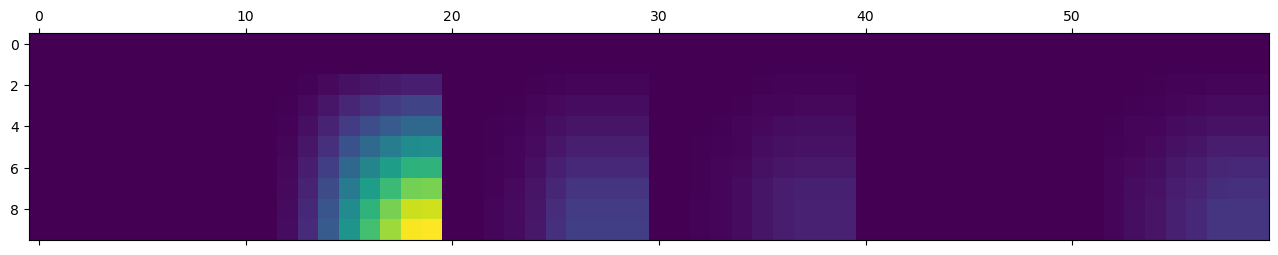

In [350]:
plt.matshow(np.hstack([f2[4, i, :, :] for i in range(6)]))

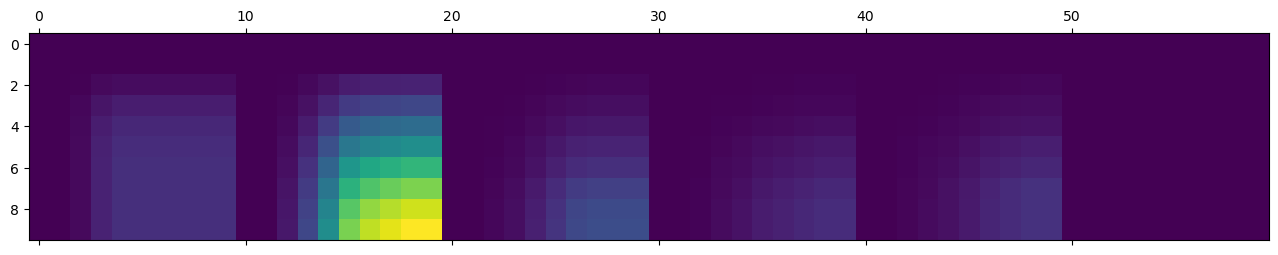

In [351]:
plt.matshow(np.hstack([f2[5, i, :, :] for i in range(6)]))

In [352]:
pearsonr(lm.predict(Xtv), np.array([predict_x(Xraw_v[i], f0, f1, f2) for i in range(len(Xtv))]))

PearsonRResult(statistic=0.9731103780023241, pvalue=0.0)

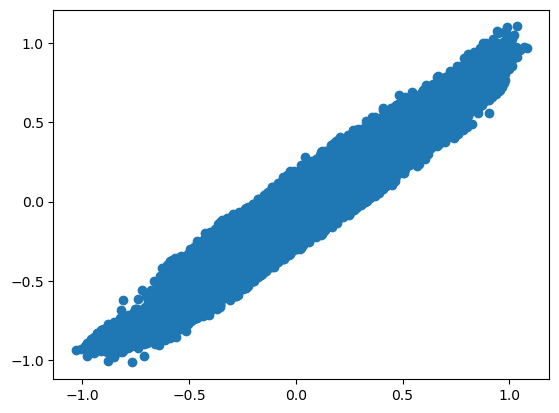

In [353]:
plt.scatter(lm.predict(Xtv), np.array([predict_x(Xraw_v[i], f0, f1, f2) for i in range(len(Xtv))]))

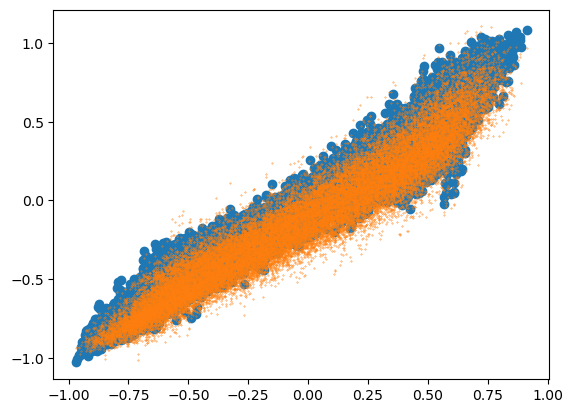

In [354]:
plt.scatter(ytv, lm.predict(Xtv))
plt.scatter(ytv, np.array([predict_x(Xraw_v[i], f0, f1, f2) for i in range(len(Xtv))]), s= 0.1)

In [340]:
pearsonr(ytv, np.array([predict_x(Xraw_v[i], f0, f1, f2) for i in range(len(Xtv))]))

PearsonRResult(statistic=0.9275580385407097, pvalue=0.0)

## Positive basis pursuit

In [ ]:
def basis_pursuit(X, y, nits):
    #lr = ElasticNet(alpha = 1.0, l1_ratio = 0)
    lr = LinearRegression()
    p = X.shape[1]
    rs = np.array([pearsonr(X[:, i], y)[0] for i in range(p)])
    inds = [np.argmax(rs)]
    for iter in range(nits):
        lr.fit(X[:, inds], y)
        resid = y - (lr.intercept_ + 1.0 * np.dot(X[:, inds], lr.coef_))
        rs = np.array([pearsonr(X[:, i], resid)[0] for i in range(p)])
        print(np.mean(np.abs(y - lr.predict(X[:, inds]))))
        inds.append(np.argmax(rs))
    return inds

In [16]:
pf3 = PolynomialFeatures(3, interaction_only = True)
X3 = pf3.fit_transform(expand_x(X))

In [17]:
featnames3 = np.array(['*'.join(featnames1[np.nonzero(row)[0]]) for row in pf3.powers_])

In [18]:
X3.shape

(330544, 18473)

In [19]:
r2i = {tuple(x[::1000]):i for i, x in enumerate(X3.T)}
X3i = np.unique(X3[::1000], axis = 1)

In [23]:
u_inds = np.sort(np.array([r2i[tuple(x)] for x in X3i.T]))

In [ ]:
X3 = X3[:, u_inds]
featnames3 = featnames3[u_inds]

In [ ]:
featnames3 = np.array([fnd[tuple(x[::1000])] for x in X3.T])

In [510]:
len(fnd)

41

In [504]:
inds = basis_pursuit(X3[perm[:ntrain], 1:], y[perm[:ntrain]], 100)

/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+04, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.2989210970575182


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.159e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.257730044241186


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.503e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.22585053829586957


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.962e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.21633011079323455


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.197e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.19878820078220386


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.190e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.17538387376052397


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.11221410458188057


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.10402893723508491


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09752590771788415


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09274854251169887


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09269285706873409


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09213733028285696


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09180479874484311


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09154548780135913


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.091380229248728


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09099937235032104


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09070960339266862


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09052413300687741


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09051510693571452


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09027891933489286


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.09007405258195049


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08993518441732361


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08989408186108072


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08975244022957662


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.171e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.0897323235166657


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08963988100361399


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.169e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08960563647775732


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.0894970754291069


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08948414045317306


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.148e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.08942120366485332


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.0893426819276291


/Users/zhengchy/miniconda3/envs/julia/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+03, tolerance: 3.139e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


0.0892737169109755


KeyboardInterrupt: 

In [466]:
featnames3[inds]

array(['I(h>=2)*I(f>=2)*I(l>=2)', 'I(f>=2)*I(p>=2)*I(s>=2)',
       'I(h>=2)*I(r>=2)', 'I(h>=2)*I(l>=2)*I(s>=2)', 'I(f>=2)*I(r>=2)',
       'I(h>=2)*I(f>=2)', 'I(h>=2)*I(l>=2)', 'I(f>=2)*I(s>=2)',
       'I(f>=2)*I(p>=2)', 'I(r>=2)*I(s>=2)', 'I(l>=2)*I(p>=2)*I(s>=2)',
       'I(f>=2)*I(p>=2)*I(r>=2)', 'I(s>=2)', 'I(l>=2)*I(r>=2)*I(s>=2)',
       'I(r>=2)', 'I(f>=2)', 'I(f>=2)*I(l>=2)*I(s>=2)', 'I(h>=2)',
       'I(f>=2)*I(r>=2)*I(s>=2)', 'I(f>=2)*I(l>=2)*I(p>=2)',
       'I(l>=2)*I(s>=2)'], dtype='<U23')